<a href="https://colab.research.google.com/github/jshogland/SpatialModelingTutorials/blob/main/Notebooks/raster_tools_surface.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Demonstration to show how to download and use raster_tools surface module within Colab
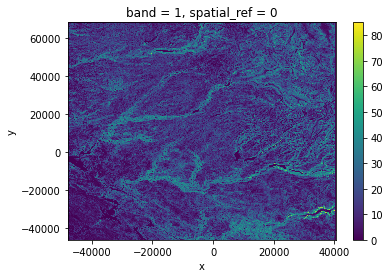

Author: John Hogland

# Install dependencies and raster_tools

In [ ]:
!pip install --upgrade gdown
!pip install --upgrade numba
!pip install --upgrade geopandas
!pip install mapclassify
!pip install --upgrade datascience
!pip install --upgrade gym
!pip install --upgrade folium
!pip install raster_tools
!pip install graphviz

## Downlaod the data

In [ ]:
import gdown, zipfile
url='https://drive.google.com/file/d/1VT-S3kHaz79STr8ydIun8T9Am3-WmD50/view?usp=sharing'
outfl= r'./SNF_Notebook_Data.zip'
gdown.download(url=url,output=outfl,quiet=False,fuzzy=True)
with zipfile.ZipFile(outfl, 'r') as zip_ref:
    zip_ref.extractall(".")

# Import the tools and create a delayed reading raster surface (elevation). Look at how the data are chunked:

1.   small dataset (Stanislaus NF extent ~2.5 million acres @ 30m)
2.   one chunk

Note, the data could be chunked to take advantage of parallel processing (see notebook [rumple_index](https://colab.research.google.com/drive/1xfQM-aCjCR7JPj45ukXYv38xr4XJu5Wi?usp=sharing)).



In [ ]:
from raster_tools import Raster, surface
elev_path = './DEM30.tif'
elv=Raster(elev_path)
elv.xrs

# Convert the elevation raster surface to aspect, slope, curvature, northing, easting, hillshade, and 3d surface area raster datasets.
We could do far more including arithmetic, conditional, logical, focal, convolution, local, aggregation, distance etc. but will use common surface module functions for this example.

In [ ]:
asp=surface.aspect(elv)
sl=surface.slope(elv)
cur=surface.curvature(elv)
northing=surface.northing(elv)
easting=surface.easting(elv)
hillshade=surface.hillshade(elv)
s3d=surface.surface_area_3d(elv)

#use logical and arithmetic operations to change all cell values less than 0 to zero and plot results for slope raster (this could also be done with the remap function)
#note, nothing has been processed until ploting the results
((sl > 0) * sl).xrs.plot()


# Calculate the mean value of all cells greater than a value (cvl=0)
As one final example we will calculate means for surface raster cell values greater than a specified value (cvl=0) and cell counts for values less than that value.

In [ ]:
rslst=[asp,sl,cur,northing, easting, hillshade,s3d]
cvl=0 #compare value
for r in rslst:
  rxr=r.xrs
  mv=rxr.where(rxr>=cvl).mean().values #conditional statement and mean calculation
  cnt=(rxr<cvl).sum().values #counts for the alternative
  print("Mean = " + str(mv) + ": < compare value count = " + str(cnt))


# Plot Aspect for values setting values less than zero equal to 0

In [ ]:
((asp>=0)*asp).xrs.plot()

View the process chain of 3d surface area 

In [ ]:
s3d._rs.data.visualize()

# Visualize in Folium
we will use some raster math to normalize cell values between 0 and 1, reproject our raster to lat long, and then display the raster within folium with a streetmap backdrop. Note, all pixels are processed multiple time.

In [ ]:
from matplotlib import cm
import folium
from folium import plugins

#Step 1: Normalize the data and get color map
#address no data values for plotting
dxr = s3d._rs
s3d._rs.data = dxr.where(dxr != s3d.null_value) #masking no data
#getting normalization values
l=s3d._rs[0].min().values.item()
u=s3d._rs[0].max().values.item()
s3dn=(s3d-l)/(u-l)
cmap=cm.get_cmap('coolwarm')


#Step 2: reproject to lat lon
xds_utm = s3dn._rs.rio.reproject("epsg:4326") #we need to reproject our results to lat lon
w,s,e,n=xds_utm.rio.bounds() #get the bounds
bnd = [[s,w],[n,e]] #set the bound for folium
data=cmap(xds_utm[0])

#Step 3: build out the map
m=folium.Map()
folium.raster_layers.ImageOverlay(image=data,bounds=bnd,mercator_project=True,name='s3d').add_to(m) #add the raster
m.fit_bounds(bnd)
fs=plugins.Fullscreen()
m.add_child(fs)
folium.LayerControl().add_to(m) # add the layer control
m #view the map